In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
#         tf.config.set_logical_device_configuration(
#             gpus[0],
#             [tf.config.LogicalDeviceConfiguration(memory_limit=5000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

from tensorflow import keras
from tifffile import imsave, imread, imwrite
from keras.models import Input, Model
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler
from tifffile import imwrite

from datagenerator_2D import data_generator
from model_2D_interconnect import make_generator
# from Model_2D_Unet import make_generator

from loss_2D import generator_loss
from skimage import exposure
from skimage.exposure import match_histograms
from skimage.exposure import histogram

1 Physical GPUs, 1 Logical GPUs


In [2]:
patch_size = 256
n_patches =  16
n_channel =  0
augment = False 
shuffle = True 
batch_size = 1
add_noise=False

GT_image_dr = r'D:\Projects\Denoising-STED\20220913-RPI\mitochondria\1frame\Average.tif'
lowSNR_image_dr =r'D:\Projects\Denoising-STED\20220913-RPI\mitochondria\1frame\1frame.tif'


# GT_image_dr = r'D:\Projects\Denoising-STED\20220913-RPI\tubulin-histone\train\Average.tif'
# lowSNR_image_dr =r'D:\Projects\Denoising-STED\20220913-RPI\tubulin-histone\train\1frame.tif'


x_train, y_train, x_valid, y_valid = data_generator(GT_image_dr, lowSNR_image_dr, patch_size, n_patches,
                                                    n_channel, threshold = 0,ratio=1.0,lp=0.01, augment=augment, shuffle=shuffle,
                                                   add_noise=add_noise)

(15, 1, 2048, 2048)
3840
The training set shape is: (3840, 256, 256, 1)
The validation set shape is: (0, 256, 256, 1)


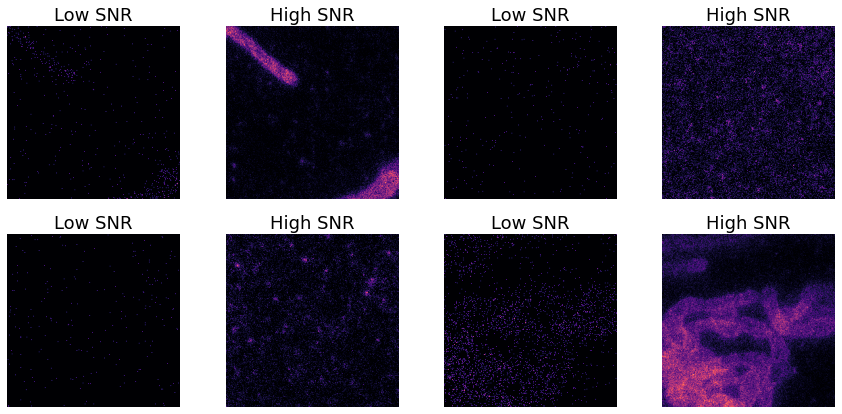

In [3]:
ix = random.sample(range(len(x_train)),4)
fig = plt.figure(figsize=(15,7))

for i in range(4):
    norm_x = np.linalg.norm(x_train[ix[i]], axis=(0, 1))
    fig.add_subplot(2,4, 2*i+1)
    cmap=plt.get_cmap('magma')
    plt.imshow(x_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('Low SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')
    
    fig.add_subplot(2,4, 2*i+2)
    cmap=plt.get_cmap('magma')
    plt.imshow(y_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('High SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

In [4]:
model_save_directory = r"D:\Projects\Denoising-STED\20220913-RPI\mitochondria\1frame\mitochondria_2step_1frameh5" 
load_model_save_directory = r"D:\Projects\Denoising-STED\20220913-RPI\tubulin-histone\histon_2step.h5" 


n_epochs =  400
gen_lr = 1e-4

filters =[64,128,256]
# filters =[80,160,320,640]
num_filters = filters[0]
filters_cab=num_filters/8
num_RG=3
num_RCAB=8

generator_input = Input((patch_size, patch_size,1))
generator = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB,
                           kernel_shape=3,dropout=0.2)
gen_opt = keras.optimizers.Adam(learning_rate=gen_lr)
generator.compile(optimizer=gen_opt, loss=generator_loss)
generator.load_weights(load_model_save_directory)



lr_max = 1e-4
lr_min = 1e-6
T = 40
a1 = 0.7
a2 = 0.7
def scheduler(epoch, lr):
    lr_min_i = a1**np.floor((epoch)/T)*lr_min
    lr_max_i = a2**np.floor((epoch)/T)*lr_max
    lr = lr_min_i+0.5*(lr_max_i-lr_min_i)*(1+np.cos(np.pi*np.mod(epoch,T)/(T-1)))
    return lr

# def scheduler(epoch, lr):
#     lr = 1e-9*10**(epoch/20)
#     return lr

# lr_max = 2e-4
# lr_min = 1e-6
# a1 = 0.6
# T = 20
# def scheduler(epoch, lr):
#     if lr>lr_min:
#         lr = gen_lr*(a1**np.floor((epoch+1)/T))
#     else:
#         lr = lr_min
#     return lr

callbacks = [
    LearningRateScheduler(scheduler),
    ModelCheckpoint(filepath=model_save_directory, verbose=1, save_best_only=True, save_weights_only=True)]

# callbacks = [
#     EarlyStopping(patience=100, verbose=1),
#     ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=10),
#     ModelCheckpoint(filepath=model_save_directory, verbose=1, save_best_only=True, save_weights_only=True)]

# callbacks = [LearningRateScheduler(scheduler)]


In [ ]:
results = generator.fit(x=x_train,y=y_train, batch_size=batch_size, epochs=n_epochs,verbose=1,
                        callbacks=callbacks,validation_split=0.1)

Epoch 1/400
3456/3456 [==============================] - ETA: 0s - loss: 0.1917 - conv2d_36_loss: 0.0959 - add_39_loss: 0.0958
Epoch 00001: val_loss improved from inf to 0.18664, saving model to D:\Projects\Denoising-STED\20220913-RPI\mitochondria\1frame\mitochondria_2step_1frameh5
3456/3456 [==============================] - 461s 131ms/step - loss: 0.1917 - conv2d_36_loss: 0.0959 - add_39_loss: 0.0958 - val_loss: 0.1866 - val_conv2d_36_loss: 0.0937 - val_add_39_loss: 0.0929 - lr: 1.0000e-04
Epoch 2/400
3456/3456 [==============================] - ETA: 0s - loss: 0.1902 - conv2d_36_loss: 0.0952 - add_39_loss: 0.0950
Epoch 00002: val_loss did not improve from 0.18664
3456/3456 [==============================] - 451s 131ms/step - loss: 0.1902 - conv2d_36_loss: 0.0952 - add_39_loss: 0.0950 - val_loss: 0.1880 - val_conv2d_36_loss: 0.0945 - val_add_39_loss: 0.0935 - lr: 9.9839e-05
Epoch 3/400
3456/3456 [==============================] - ETA: 0s - loss: 0.1890 - conv2d_36_loss: 0.0947 - add_

3456/3456 [==============================] - ETA: 0s - loss: 0.1742 - conv2d_36_loss: 0.0878 - add_39_loss: 0.0864
Epoch 00018: val_loss did not improve from 0.17432
3456/3456 [==============================] - 451s 130ms/step - loss: 0.1742 - conv2d_36_loss: 0.0878 - add_39_loss: 0.0864 - val_loss: 0.1754 - val_conv2d_36_loss: 0.0884 - val_add_39_loss: 0.0869 - lr: 6.0401e-05
Epoch 19/400
3456/3456 [==============================] - ETA: 0s - loss: 0.1737 - conv2d_36_loss: 0.0876 - add_39_loss: 0.0861
Epoch 00019: val_loss improved from 0.17432 to 0.17399, saving model to D:\Projects\Denoising-STED\20220913-RPI\mitochondria\1frame\mitochondria_2step_1frameh5
3456/3456 [==============================] - 452s 131ms/step - loss: 0.1737 - conv2d_36_loss: 0.0876 - add_39_loss: 0.0861 - val_loss: 0.1740 - val_conv2d_36_loss: 0.0878 - val_add_39_loss: 0.0862 - lr: 5.6467e-05
Epoch 20/400
3456/3456 [==============================] - ETA: 0s - loss: 0.1732 - conv2d_36_loss: 0.0874 - add_39_los

3456/3456 [==============================] - 450s 130ms/step - loss: 0.1686 - conv2d_36_loss: 0.0855 - add_39_loss: 0.0831 - val_loss: 0.1699 - val_conv2d_36_loss: 0.0859 - val_add_39_loss: 0.0840 - lr: 4.9610e-06
Epoch 36/400
3456/3456 [==============================] - ETA: 0s - loss: 0.1685 - conv2d_36_loss: 0.0855 - add_39_loss: 0.0830
Epoch 00036: val_loss did not improve from 0.16985
3456/3456 [==============================] - 449s 130ms/step - loss: 0.1685 - conv2d_36_loss: 0.0855 - add_39_loss: 0.0830 - val_loss: 0.1700 - val_conv2d_36_loss: 0.0860 - val_add_39_loss: 0.0840 - lr: 3.5474e-06
Epoch 37/400
3456/3456 [==============================] - ETA: 0s - loss: 0.1684 - conv2d_36_loss: 0.0855 - add_39_loss: 0.0830
Epoch 00037: val_loss did not improve from 0.16985
3456/3456 [==============================] - 449s 130ms/step - loss: 0.1684 - conv2d_36_loss: 0.0855 - add_39_loss: 0.0830 - val_loss: 0.1701 - val_conv2d_36_loss: 0.0860 - val_add_39_loss: 0.0841 - lr: 2.4384e-06


Epoch 56/400
3456/3456 [==============================] - ETA: 0s - loss: 0.1680 - conv2d_36_loss: 0.0856 - add_39_loss: 0.0825
Epoch 00056: val_loss did not improve from 0.16967
3456/3456 [==============================] - 450s 130ms/step - loss: 0.1680 - conv2d_36_loss: 0.0856 - add_39_loss: 0.0825 - val_loss: 0.1698 - val_conv2d_36_loss: 0.0861 - val_add_39_loss: 0.0836 - lr: 4.7637e-05
Epoch 57/400
3456/3456 [==============================] - ETA: 0s - loss: 0.1678 - conv2d_36_loss: 0.0855 - add_39_loss: 0.0823
Epoch 00057: val_loss improved from 0.16967 to 0.16961, saving model to D:\Projects\Denoising-STED\20220913-RPI\mitochondria\1frame\mitochondria_2step_1frameh5
3456/3456 [==============================] - 451s 131ms/step - loss: 0.1678 - conv2d_36_loss: 0.0855 - add_39_loss: 0.0823 - val_loss: 0.1696 - val_conv2d_36_loss: 0.0861 - val_add_39_loss: 0.0835 - lr: 4.4990e-05
Epoch 58/400
3456/3456 [==============================] - ETA: 0s - loss: 0.1675 - conv2d_36_loss: 0.0854

3456/3456 [==============================] - ETA: 0s - loss: 0.1645 - conv2d_36_loss: 0.0843 - add_39_loss: 0.0803
Epoch 00074: val_loss did not improve from 0.16737
3456/3456 [==============================] - 463s 134ms/step - loss: 0.1645 - conv2d_36_loss: 0.0843 - add_39_loss: 0.0803 - val_loss: 0.1674 - val_conv2d_36_loss: 0.0851 - val_add_39_loss: 0.0823 - lr: 4.6689e-06
Epoch 75/400
3456/3456 [==============================] - ETA: 0s - loss: 0.1645 - conv2d_36_loss: 0.0843 - add_39_loss: 0.0802
Epoch 00075: val_loss did not improve from 0.16737
3456/3456 [==============================] - 459s 133ms/step - loss: 0.1645 - conv2d_36_loss: 0.0843 - add_39_loss: 0.0802 - val_loss: 0.1676 - val_conv2d_36_loss: 0.0853 - val_add_39_loss: 0.0823 - lr: 3.4727e-06
Epoch 76/400
3456/3456 [==============================] - ETA: 0s - loss: 0.1644 - conv2d_36_loss: 0.0842 - add_39_loss: 0.0802
Epoch 00076: val_loss did not improve from 0.16737
3456/3456 [==============================] - 456